In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
AAPL = pd.read_csv("hist_data/AAPL.csv")

In [12]:
AAPL[:365]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-23,23.967501,24.297501,23.917500,24.107500,22.520861,152074400
1,2016-05-24,24.305000,24.522499,24.209999,24.475000,22.864182,140560800
2,2016-05-25,24.667500,24.934999,24.527500,24.905001,23.265877,152675200
3,2016-05-26,24.920000,25.182501,24.660000,25.102501,23.450378,225324800
4,2016-05-27,24.860001,25.117500,24.812500,25.087500,23.436363,145364800
...,...,...,...,...,...,...,...
360,2017-10-25,39.227501,39.387501,38.817501,39.102501,37.374687,84828400
361,2017-10-26,39.307499,39.457500,39.195000,39.352501,37.613644,68002000
362,2017-10-27,39.822498,40.900002,39.674999,40.762501,38.961342,177816800
363,2017-10-30,40.972500,42.017502,40.930000,41.680000,39.838306,178803200


In [317]:
def prices2returns(prices):
    return np.array([(prices[i+1] - prices[i]) / prices[i] for i in range(len(prices)-1)])

def returns2prices(p0, returns):
    if len(returns.shape) == 1:
        L = returns.shape[0];
        prices = np.zeros(L+1)
        prices[0] = p0

        for i in range(L):
            prices[i+1] = prices[i] + prices[i]*returns[i]
    else:
        prices = np.array([returns2prices(p0, r) for r in returns])
    
    return prices[1:]

# def returns2final_price(p0, returns):
#     L = len(returns);
#     final_price = p0
    
#     for i in range(L):
#         final_price = final_price + final_price*returns[i]
    
#     return final_price
        
class BaseModel:
    def __init__(self, data=None):
        self.prices = data['Close'].to_numpy()
        self.data = data
        self.returns = None
        self.pseudo_returns = None
        self.T = 0
        self.date_format = "%Y-%m-%d"
        self.dates = [datetime.datetime.strptime(date, self.date_format).date() for date in self.data['Date'][:]]
    
    def get_returns(self, T, F=0):
        prices = self.prices[F:T]
        self.returns = prices2returns(prices)
        self.T = T
    
    def extend_returns(self, T):
        prices = self.prices[self.T-1:self.T+T]
        self.returns = np.append(self.returns, prices2returns(prices))
        self.T += T
    
    def simulate(self, steps, trials, T=None, F=0):
        self.pseudo_returns = np.zeros([trials, steps])
        
    def plot_last_simulation(self, N=10, padding=10, real_price=False):
        steps = self.pseudo_returns.shape[1]
        p0 = self.prices[self.T-1]
        if steps <= 0: return
        
        plt.figure(figsize=(10,5))
        plt.grid(True)
            
        simulated_prices = returns2prices(p0, self.pseudo_returns[np.random.randint(self.pseudo_returns.shape[0], size=N), :])
        
        for sp in simulated_prices:
            sp = np.append(np.array([p0]), sp)
            plt.plot(self.dates[self.T-1:self.T+steps], sp, color='green', linewidth=0.2)
            
        print(self.dates[self.T-1], self.dates[self.T+steps], steps)
            
        end = self.T+steps if real_price else self.T 
        plt.plot(self.dates[self.T-padding:end], self.prices[self.T-padding:end], color='blue', linewidth=2)
            
        
    def plot(self, begin=0, end=None):
        if not end: end = len(self.prices)
        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.plot(self.dates[begin:end], self.prices[begin:end])
    
    def evaluate(self, q):
#         pseudo_prices = np.array([
#             returns2prices(trial) for trial in self.pseudo_returns
#         ])
#         print(pseudo_prices)
        pass

In [318]:
class RandomSampling(BaseModel):
    def __init__(self, data):
        super().__init__(data)
    
    def simulate(self, steps, trials, T=None, F=0):
        if T: self.get_returns(T, F)
        self.pseudo_returns = np.array([
            np.random.permutation(np.random.choice(self.returns, steps)) for _ in range(trials)
        ])
        return self.pseudo_returns

2017-10-31 2017-12-14 30


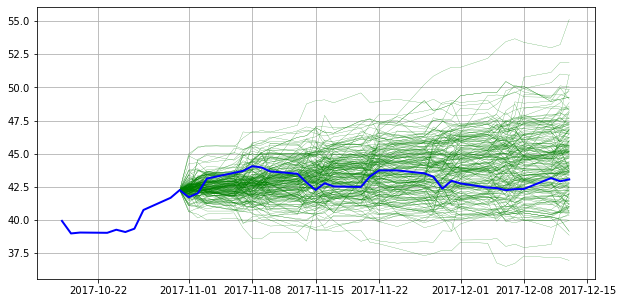

In [319]:
RS = RandomSampling(AAPL)
RS.simulate(steps=30, trials=2000, T=365)
RS.plot_last_simulation(200, real_price=True)

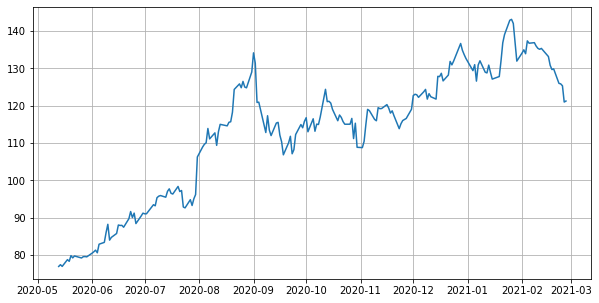

In [294]:
RS.plot(1000, 1200)